# Step 4: Evaluation and Backtesting

This notebook performs comprehensive evaluation and backtesting:
- Evaluate local Sharpe-variant scores
- Plot cumulative returns and volatility ratios
- Compare against the S&P 500 baseline
- Analyze relationship between volatility, drawdown, and Sharpe performance

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Make charts look nice (like choosing a color theme for your phone)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Settings for creating new data columns from old ones (like looking at yesterday's weather to predict today)
LAGS = [1, 3, 5]
ROLL_WINDOWS = [5, 10]
FEATURE_COLS = ['E19', 'E3', 'E2', 'E4', 'E13', 'S2', 'S5', 'S6', 'V3', 'V13', 'V7', 'V5', 'I6', 'I2', 'M4', 'M3', 'M12', 'P11', 'P5', 'P10']
TARGET = "market_forward_excess_returns"

def create_features(df, base_cols):
    """Add new columns using past data. Like checking last week's sales to guess next week's."""
    df = df.copy()
    
    # Look at values from 1, 3, 5 days ago (like checking what you ate yesterday)
    for col in base_cols:
        for lag in LAGS:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    
    # Calculate averages over last 5 or 10 days (like your average sleep this week)
    for col in base_cols:
        for w in ROLL_WINDOWS:
            df[f"{col}_roll_mean_{w}"] = df[col].rolling(w).mean()
            df[f"{col}_roll_std_{w}"]  = df[col].rolling(w).std()
    
    df = df.ffill().bfill().fillna(0)
    return df

print("Feature engineering functions defined")

Feature engineering functions defined


In [ ]:
# The grading system Kaggle uses to score our predictions (like a test score from 0 to 1)
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name=None) -> float:
    """Calculate the competition score. High score = good predictions. Penalizes risky and poor strategies."""
    
    if not pd.api.types.is_numeric_dtype(submission['prediction']):
        raise ValueError('Predictions must be numeric')
    
    solution = solution.copy()
    solution['position'] = submission['prediction']
    
    # How much money we make (like profit from a shop: sales minus costs)
    strategy_returns = (
        solution['risk_free_rate'] * (1 - solution['position']) +
        solution['position'] * solution['forward_returns']
    )
    
    strategy_excess_returns = strategy_returns - solution['risk_free_rate']
    strat_cum = (1 + strategy_excess_returns).prod()
    strat_mean = strat_cum ** (1/len(solution)) - 1
    strategy_std = strategy_returns.std()
    
    trading_days = 252
    if strategy_std == 0:
        return 0.0
    
    sharpe = strat_mean / strategy_std * np.sqrt(trading_days)
    strategy_vol = float(strategy_std * np.sqrt(trading_days) * 100)
    
    # How the stock market did (the S&P 500, like comparing your shop to a big store)
    market_excess = solution['forward_returns'] - solution['risk_free_rate']
    market_cum = (1 + market_excess).prod()
    market_mean = market_cum ** (1/len(solution)) - 1
    market_std = solution['forward_returns'].std()
    market_vol = float(market_std * np.sqrt(trading_days) * 100)
    
    # Penalty for being too risky (like losing points for driving too fast)
    excess_vol = max(0, strategy_vol/market_vol - 1.2)
    vol_penalty = 1 + excess_vol
    
    # Penalty for making less money than the market (like losing points for being slower than others)
    return_gap = max(0, (market_mean - strat_mean) * 100 * trading_days)
    return_penalty = 1 + (return_gap**2)/100
    
    adjusted = sharpe / (vol_penalty * return_penalty)
    return float(min(adjusted, 1_000_000))


def returns_to_allocation(pred):
    """Turn predictions into investment amounts. 0 = invest nothing, 2 = invest double (like betting more when confident)."""
    if pred <= 0:
        return 0.0
    if pred >= 0.01:
        return 2.0
    return 2.0 * (pred / 0.01)


def kaggle_local_score(model, X_valid, df_valid):
    """Test how good our model is on data it hasn't seen (like a practice test before the real exam)."""
    raw_preds = model.predict(X_valid)
    raw_preds = np.clip(raw_preds, -0.05, 0.05)
    
    allocs = np.array([returns_to_allocation(p) for p in raw_preds])
    
    submission = pd.DataFrame({"prediction": allocs})
    solution = pd.DataFrame({
        "forward_returns": df_valid["forward_returns"].values,
        "risk_free_rate": df_valid["risk_free_rate"].values
    })
    
    return score(solution, submission)

print("Scoring functions defined")

Scoring functions defined


In [ ]:
def calculate_performance_metrics(returns_series, name="Strategy"):
    """Calculate different ways to measure success (like checking grades, attendance, and homework all together)."""
    
    # Change data format so we can do math on it
    returns = returns_series.values if isinstance(returns_series, pd.Series) else returns_series
    
    # Total profit: If you started with $100, how much do you have now?
    total_return = (1 + returns).prod() - 1
    n_periods = len(returns)
    annualized_return = (1 + total_return) ** (252 / n_periods) - 1
    
    # Risk level: How much prices jump up and down (like a rollercoaster vs a slow train)
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe: Profit divided by risk. Higher = better. Like getting good grades with less study time.
    sharpe_ratio = (annualized_return / volatility) if volatility > 0 else 0
    
    # Sortino: Like Sharpe, but only counts bad days. We care more about losses than gains.
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = (annualized_return / downside_std) if downside_std > 0 else 0
    
    # Drawdown: The biggest drop from your highest point (like losing weight after your best weight)
    cumulative = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar: Profit divided by biggest loss. Higher = you recover well from bad times.
    calmar_ratio = (annualized_return / abs(max_drawdown)) if max_drawdown != 0 else 0
    
    # Win rate: How often you make money (like winning 6 out of 10 games = 60%)
    win_rate = (returns > 0).sum() / len(returns) * 100
    
    # Profit factor: Total wins divided by total losses. Above 1 = you make more than you lose.
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    
    # VaR: Worst expected loss on a bad day (5% chance). Like: "95% of the time, you won't lose more than X."
    var_95 = np.percentile(returns, 5)
    cvar_95 = returns[returns <= var_95].mean()
    
    metrics = {
        'Total Return (%)': total_return * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Volatility (%)': volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'VaR 95% (%)': var_95 * 100,
        'CVaR 95% (%)': cvar_95 * 100,
    }
    
    return metrics


def comprehensive_backtest(model, train_df, feature_cols, target_col, n_splits=5):
    """
    Test our strategy on past data to see if it would have worked.
    Like practicing with old exam papers before the real test.
    Splits data into 5 parts and tests each one separately.
    """
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_results = []
    fold_metrics = []
    fold_kaggle_scores = []
    
    FE_FEATURE_COLS = None
    
    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(train_df)):
        print(f"\n{'='*60}")
        print(f"Processing Fold {fold_idx + 1}/{n_splits}")
        print(f"{'='*60}")
        # Divide data into training (to learn) and testing (to check) parts
        df_train_fold = train_df.iloc[train_idx].copy()
        df_valid_fold = train_df.iloc[valid_idx].copy()
        # Add new columns to training data (past values, averages, etc.)
        # Feature engineering on train
        df_train_fe = create_features(df_train_fold, feature_cols)
        # Add new columns to test data carefully (don't peek at future data - that's cheating!)
        # Feature engineering on train+valid (to avoid leakage in rolling features)
        df_combined = pd.concat([df_train_fold, df_valid_fold], ignore_index=True)
        df_combined_fe = create_features(df_combined, feature_cols)
        df_valid_fe = df_combined_fe.iloc[len(df_train_fold):].copy()
        # Save the list of columns we use (only need to do this once)
        # Define feature columns once
        if FE_FEATURE_COLS is None:
            FE_FEATURE_COLS = [
                c for c in df_train_fe.columns
                if c not in [target_col, "forward_returns", "risk_free_rate", "date_id"]
            ]
            print(f"Number of features: {len(FE_FEATURE_COLS)}")
        # Get the input (X) and answer (y) for teaching the model
        # Prepare training data
        X_train = df_train_fe[FE_FEATURE_COLS]
        y_train = df_train_fe[target_col]
        
        X_valid = df_valid_fe[FE_FEATURE_COLS]
        y_valid = df_valid_fe[target_col]
        # Teach the model using training data (like studying for an exam)
        # Train model
        print(f"Training model on {len(X_train)} samples...")
        model.fit(X_train, y_train)
        # Model makes guesses on test data (like answering exam questions)
        # Make predictions
        raw_preds = model.predict(X_valid)
        raw_preds = np.clip(raw_preds, -0.05, 0.05)
        # Turn predictions into investment decisions (0 = no investment, 2 = invest double)
        # Convert to allocations
        allocations = np.array([returns_to_allocation(p) for p in raw_preds])
        # Calculate how much money our strategy makes each day
        # Calculate strategy returns
        strategy_returns = (
            df_valid_fold['risk_free_rate'].values * (1 - allocations) +
            allocations * df_valid_fold['forward_returns'].values
        )
        
        strategy_excess = strategy_returns - df_valid_fold['risk_free_rate'].values
        market_returns = df_valid_fold['forward_returns'].values
        market_excess = market_returns - df_valid_fold['risk_free_rate'].values
        # Add up all profits over time (like a running total of your savings)
        # Calculate cumulative returns
        strategy_cumulative = (1 + strategy_excess).cumprod()
        market_cumulative = (1 + market_excess).cumprod()
        rf_cumulative = (1 + df_valid_fold['risk_free_rate'].values).cumprod()
        # Track biggest drops from peak (like your bank balance falling after spending)
        # Calculate drawdowns
        strategy_running_max = np.maximum.accumulate(strategy_cumulative)
        strategy_drawdown = (strategy_cumulative - strategy_running_max) / strategy_running_max
        
        market_running_max = np.maximum.accumulate(market_cumulative)
        market_drawdown = (market_cumulative - market_running_max) / market_running_max
        # Check performance over last 60 days (like your last 2 months of grades)
        # Calculate rolling Sharpe ratios (60-day window)
        window = 60
        strategy_rolling_sharpe = pd.Series(strategy_returns).rolling(window).apply(
            lambda x: (x.mean() / x.std() * np.sqrt(252)) if x.std() > 0 else 0
        )
        market_rolling_sharpe = pd.Series(market_returns).rolling(window).apply(
            lambda x: (x.mean() / x.std() * np.sqrt(252)) if x.std() > 0 else 0
        )
        # Check risk level over last 60 days (how bumpy the ride has been)
        # Calculate rolling volatilities
        strategy_rolling_vol = pd.Series(strategy_returns).rolling(window).std() * np.sqrt(252) * 100
        market_rolling_vol = pd.Series(market_returns).rolling(window).std() * np.sqrt(252) * 100
        # Save all the numbers for this test period
        # Store detailed results
        fold_results = pd.DataFrame({
            'date_id': df_valid_fold['date_id'].values,
            'fold': fold_idx + 1,
            'allocation': allocations,
            'raw_prediction': raw_preds,
            'forward_returns': df_valid_fold['forward_returns'].values,
            'risk_free_rate': df_valid_fold['risk_free_rate'].values,
            'strategy_returns': strategy_returns,
            'strategy_excess': strategy_excess,
            'market_returns': market_returns,
            'market_excess': market_excess,
            'strategy_cumulative': strategy_cumulative,
            'market_cumulative': market_cumulative,
            'rf_cumulative': rf_cumulative,
            'strategy_drawdown': strategy_drawdown,
            'market_drawdown': market_drawdown,
            'strategy_rolling_sharpe': strategy_rolling_sharpe.values,
            'market_rolling_sharpe': market_rolling_sharpe.values,
            'strategy_rolling_vol': strategy_rolling_vol.values,
            'market_rolling_vol': market_rolling_vol.values,
            'volatility_ratio': (strategy_rolling_vol / market_rolling_vol).values,
            'strategy_rolling_return': pd.Series(strategy_returns).rolling(window).sum().values * 100,
            'market_rolling_return': pd.Series(market_returns).rolling(window).sum().values * 100,
            'strategy_rolling_dd': pd.Series(strategy_drawdown).rolling(window).min().values * 100,
            'market_rolling_dd': pd.Series(market_drawdown).rolling(window).min().values * 100,
        })
        
        all_results.append(fold_results)
        # Get the competition score for this test (like a grade for this exam)
        # Calculate Kaggle score for this fold
        kaggle_score = kaggle_local_score(model, X_valid, df_valid_fold)
        fold_kaggle_scores.append(kaggle_score)
        # Get all the different ways to measure success
        # Calculate performance metrics
        strategy_metrics = calculate_performance_metrics(strategy_excess, "Strategy")
        market_metrics = calculate_performance_metrics(market_excess, "Market")
        # Save a summary of this test period (like a report card)
        # Store fold summary
        fold_summary = {
            'Fold': fold_idx + 1,
            'Samples': len(df_valid_fold),
            'Kaggle Score': kaggle_score,
            'Strategy Return (%)': strategy_metrics['Total Return (%)'],
            'Market Return (%)': market_metrics['Total Return (%)'],
            'Excess Return (%)': strategy_metrics['Total Return (%)'] - market_metrics['Total Return (%)'],
            'Strategy Vol (%)': strategy_metrics['Volatility (%)'],
            'Market Vol (%)': market_metrics['Volatility (%)'],
            'Vol Ratio': strategy_metrics['Volatility (%)'] / market_metrics['Volatility (%)'],
            'Strategy Sharpe': strategy_metrics['Sharpe Ratio'],
            'Market Sharpe': market_metrics['Sharpe Ratio'],
            'Strategy MaxDD (%)': strategy_metrics['Max Drawdown (%)'],
            'Market MaxDD (%)': market_metrics['Max Drawdown (%)'],
            'Avg Allocation': allocations.mean(),
        }
        
        fold_metrics.append(fold_summary)
        
        print(f"Kaggle Score: {kaggle_score:.4f}")
        print(f"Strategy Return: {strategy_metrics['Total Return (%)']:.2f}%")
        print(f"Market Return: {market_metrics['Total Return (%)']:.2f}%")
        print(f"Strategy Sharpe: {strategy_metrics['Sharpe Ratio']:.4f}")
        print(f"Market Sharpe: {market_metrics['Sharpe Ratio']:.4f}")
    # Put all test results together into one big table
    # Combine all fold results
    detailed_results = pd.concat(all_results, ignore_index=True)
    fold_summary_df = pd.DataFrame(fold_metrics)
    
    print(f"\n{'='*60}")
    print("OVERALL RESULTS")
    print(f"{'='*60}")
    print(f"Mean Kaggle Score: {np.mean(fold_kaggle_scores):.4f} ± {np.std(fold_kaggle_scores):.4f}")
    print(f"Mean Strategy Return: {fold_summary_df['Strategy Return (%)'].mean():.2f}%")
    print(f"Mean Market Return: {fold_summary_df['Market Return (%)'].mean():.2f}%")
    print(f"Mean Strategy Sharpe: {fold_summary_df['Strategy Sharpe'].mean():.4f}")
    print(f"Mean Market Sharpe: {fold_summary_df['Market Sharpe'].mean():.4f}")
    
    return detailed_results, fold_summary_df, FE_FEATURE_COLS

print("Backtesting function defined")

Backtesting function defined


In [ ]:
# Read the historical stock market data (like loading old weather records)
TRAIN_PATH = "../data/train.csv"
train_df = pd.read_csv(TRAIN_PATH)

print(f"Training data shape: {train_df.shape}")
print(f"Date range: {train_df['date_id'].min()} to {train_df['date_id'].max()}")

Training data shape: (9021, 98)
Date range: 0 to 9020


In [ ]:
# Set up our prediction model with the best settings we found earlier (like tuning a car engine)
best_lgbm_params = {
    "n_estimators": 800,
    "learning_rate": 0.02,
    "num_leaves": 120,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "max_depth": -1,
    "min_child_samples": 20,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0
}

lgbm_model = lgb.LGBMRegressor(**best_lgbm_params, random_state=42, verbose=-1)
print("Model initialized with best hyperparameters from Step 3")

Model initialized with best hyperparameters from Step 3


In [ ]:
# Test our strategy on 5 different time periods (like 5 practice exams)
print("Starting comprehensive backtesting...")
print("This may take a few minutes...\n")

detailed_results, fold_summary, feature_cols_used = comprehensive_backtest(
    model=lgbm_model,
    train_df=train_df,
    feature_cols=FEATURE_COLS,
    target_col=TARGET,
    n_splits=5
)

print(f"\nBacktest complete!")
print(f"Detailed results shape: {detailed_results.shape}")
print(f"Features used: {len(feature_cols_used)}")

Starting comprehensive backtesting...
This may take a few minutes...


Processing Fold 1/5
Number of features: 234
Training model on 1506 samples...
Kaggle Score: 0.6227
Strategy Return: 75.27%
Market Return: 56.16%
Strategy Sharpe: 0.6531
Market Sharpe: 0.4044

Processing Fold 2/5
Training model on 3009 samples...
Kaggle Score: 0.6227
Strategy Return: 75.27%
Market Return: 56.16%
Strategy Sharpe: 0.6531
Market Sharpe: 0.4044

Processing Fold 2/5
Training model on 3009 samples...
Kaggle Score: 0.0577
Strategy Return: 5.47%
Market Return: 11.42%
Strategy Sharpe: 0.0585
Market Sharpe: 0.1168

Processing Fold 3/5
Training model on 4512 samples...
Kaggle Score: 0.0577
Strategy Return: 5.47%
Market Return: 11.42%
Strategy Sharpe: 0.0585
Market Sharpe: 0.1168

Processing Fold 3/5
Training model on 4512 samples...
Kaggle Score: 0.2006
Strategy Return: 33.51%
Market Return: 54.36%
Strategy Sharpe: 0.2177
Market Sharpe: 0.3612

Processing Fold 4/5
Training model on 6015 samples...
Kaggle Score:

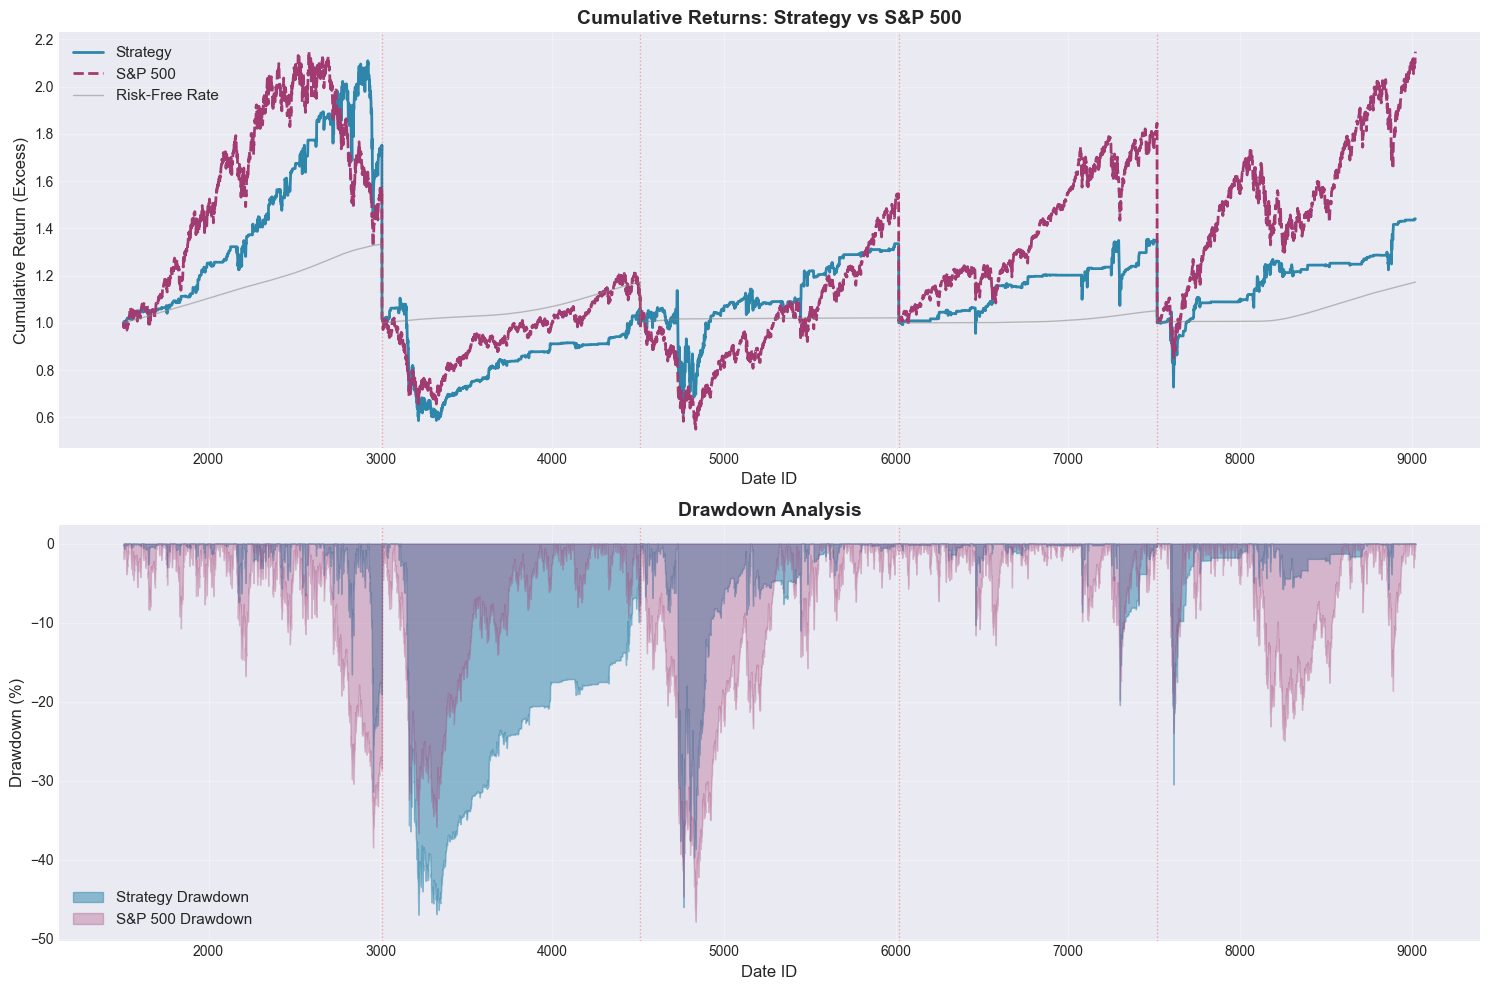

Cumulative returns plot saved to ../results/cumulative_returns_analysis.png


In [ ]:
# Draw charts showing how much money we would have made over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Chart 1: Total profit growth (like watching your savings grow)
ax1 = axes[0]
ax1.plot(detailed_results['date_id'], detailed_results['strategy_cumulative'], 
         label='Strategy', linewidth=2, color='#2E86AB')
ax1.plot(detailed_results['date_id'], detailed_results['market_cumulative'], 
         label='S&P 500', linewidth=2, color='#A23B72', linestyle='--')
ax1.plot(detailed_results['date_id'], detailed_results['rf_cumulative'], 
         label='Risk-Free Rate', linewidth=1, color='gray', alpha=0.5)

ax1.set_title('Cumulative Returns: Strategy vs S&P 500', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date ID', fontsize=12)
ax1.set_ylabel('Cumulative Return (Excess)', fontsize=12)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Draw lines to show where each test period starts (like chapter markers in a book)
fold_changes = detailed_results[detailed_results['fold'].diff() != 0].index
for idx in fold_changes[1:]:
    date_val = detailed_results.iloc[idx]['date_id']
    ax1.axvline(x=date_val, color='red', alpha=0.3, linestyle=':', linewidth=1)

# Chart 2: Drops from highest point (like weight loss after your best weight)
ax2 = axes[1]
ax2.fill_between(detailed_results['date_id'], detailed_results['strategy_drawdown'] * 100, 0,
                  alpha=0.5, label='Strategy Drawdown', color='#2E86AB')
ax2.fill_between(detailed_results['date_id'], detailed_results['market_drawdown'] * 100, 0,
                  alpha=0.3, label='S&P 500 Drawdown', color='#A23B72')

ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date ID', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.legend(loc='lower left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Draw lines to show where each test period starts
for idx in fold_changes[1:]:
    date_val = detailed_results.iloc[idx]['date_id']
    ax2.axvline(x=date_val, color='red', alpha=0.3, linestyle=':', linewidth=1)

plt.tight_layout()
plt.savefig('../results/cumulative_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cumulative returns plot saved to ../results/cumulative_returns_analysis.png")

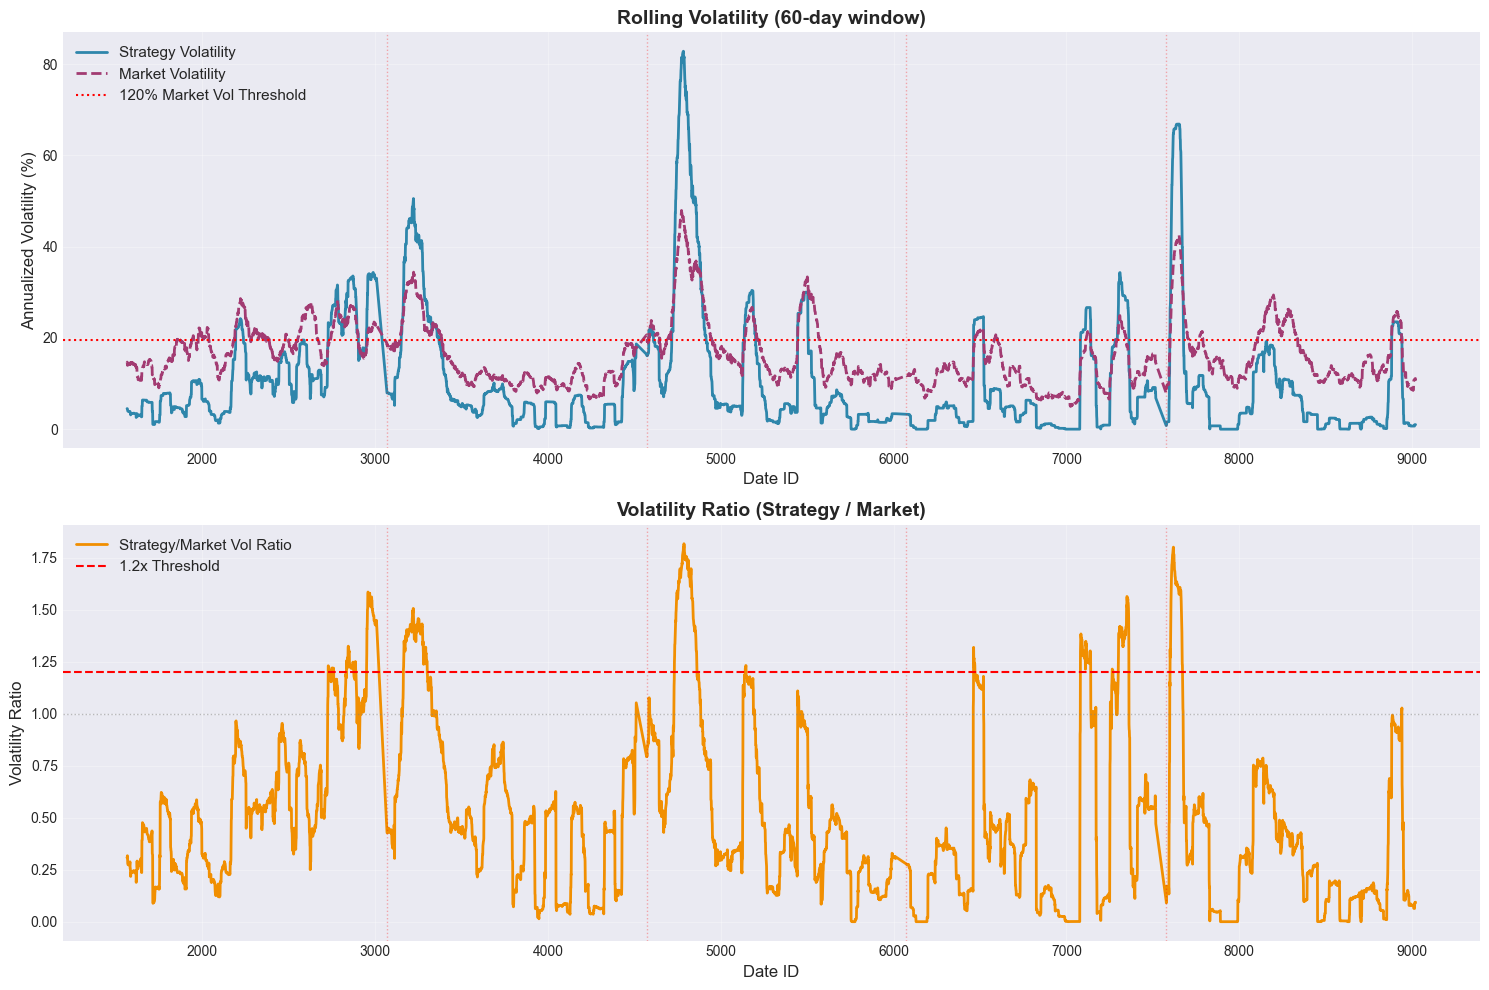

Volatility analysis plot saved to ../results/volatility_analysis.png


In [ ]:
# Draw charts showing risk levels (how bumpy the ride is)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Remove empty values (first 60 days don't have enough history)
valid_idx = ~detailed_results['strategy_rolling_vol'].isna()
valid_data = detailed_results[valid_idx]

# Chart 1: Risk level over time (higher = more risky, like a bumpy road)
ax1 = axes[0]
ax1.plot(valid_data['date_id'], valid_data['strategy_rolling_vol'], 
         label='Strategy Volatility', linewidth=2, color='#2E86AB')
ax1.plot(valid_data['date_id'], valid_data['market_rolling_vol'], 
         label='Market Volatility', linewidth=2, color='#A23B72', linestyle='--')

# Red line = danger zone. Above this line = too risky (penalty in competition)
ax1.axhline(y=valid_data['market_rolling_vol'].mean() * 1.2, 
            color='red', linestyle=':', linewidth=1.5, 
            label='120% Market Vol Threshold')

ax1.set_title('Rolling Volatility (60-day window)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date ID', fontsize=12)
ax1.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Chart 2: Our risk compared to market (1.0 = same, above 1.2 = penalty)
ax2 = axes[1]
ax2.plot(valid_data['date_id'], valid_data['volatility_ratio'], 
         label='Strategy/Market Vol Ratio', linewidth=2, color='#F18F01')
ax2.axhline(y=1.2, color='red', linestyle='--', linewidth=1.5, label='1.2x Threshold')
ax2.axhline(y=1.0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax2.set_title('Volatility Ratio (Strategy / Market)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date ID', fontsize=12)
ax2.set_ylabel('Volatility Ratio', fontsize=12)
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Draw lines to show where each test period starts
fold_changes = valid_data[valid_data['fold'].diff() != 0].index
for idx in fold_changes[1:]:
    date_val = valid_data.loc[idx, 'date_id']
    ax1.axvline(x=date_val, color='red', alpha=0.3, linestyle=':', linewidth=1)
    ax2.axvline(x=date_val, color='red', alpha=0.3, linestyle=':', linewidth=1)

plt.tight_layout()
plt.savefig('../results/volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Volatility analysis plot saved to ../results/volatility_analysis.png")

In [ ]:
# Calculate final grades for our strategy vs the market (like comparing two students)
strategy_overall_metrics = calculate_performance_metrics(detailed_results['strategy_excess'], "Strategy")
market_overall_metrics = calculate_performance_metrics(detailed_results['market_excess'], "S&P 500")

# Add the competition scores (our main grade)
strategy_overall_metrics['Kaggle Score (Mean)'] = fold_summary['Kaggle Score'].mean()
strategy_overall_metrics['Kaggle Score (Std)'] = fold_summary['Kaggle Score'].std()

# Put results in a table to compare side by side
comparison_df = pd.DataFrame({
    'Metric': list(strategy_overall_metrics.keys()),
    'Strategy': list(strategy_overall_metrics.values()),
    'S&P 500': [market_overall_metrics.get(k, '-') for k in strategy_overall_metrics.keys()]
})

# Make the table easier to read
comparison_df = comparison_df.set_index('Metric')

# Show the comparison table
print("Overall Performance Comparison: Strategy vs S&P 500")
print("="*60)
display(comparison_df)

Overall Performance Comparison: Strategy vs S&P 500


,Strategy,S&P 500
Metric,,
Total Return (%),379.505925,964.769624
Annualized Return (%),5.397187,8.254734
Volatility (%),16.333905,17.58039
Sharpe Ratio,0.330428,0.469542
Sortino Ratio,0.244212,0.636556
Max Drawdown (%),-51.341904,-55.533027
Calmar Ratio,0.105122,0.148645
Win Rate (%),21.304059,53.998669
Profit Factor,1.165680,1.099549


In [ ]:
# Explain what the numbers mean in plain English
print("="*80)
print("INTERPRETATION: VOLATILITY, DRAWDOWN, AND SHARPE PERFORMANCE")
print("="*80)

print("\n1. VOLATILITY ANALYSIS:")
print("-" * 80)
avg_strat_vol = fold_summary['Strategy Vol (%)'].mean()
avg_market_vol = fold_summary['Market Vol (%)'].mean()
avg_vol_ratio = fold_summary['Vol Ratio'].mean()

print(f"Average Strategy Volatility: {avg_strat_vol:.2f}%")
print(f"Average Market Volatility: {avg_market_vol:.2f}%")
print(f"Average Volatility Ratio: {avg_vol_ratio:.3f}")
print(f"Volatility Constraint (120%): {avg_market_vol * 1.2:.2f}%")

if avg_vol_ratio > 1.2:
    print(f" ⚠️  WARNING: Strategy volatility EXCEEDS the 120% market constraint!")
    print(f" Excess volatility: {(avg_vol_ratio - 1.2) * 100:.2f}%")
    print(f" This will result in a penalty in the Kaggle score.")
elif avg_vol_ratio > 1.0:
    print(f"✓ Strategy volatility is higher than market but within 120% constraint")
    print(f"  Extra volatility: {(avg_vol_ratio - 1.0) * 100:.2f}%")
else:
    print(f"✓ Strategy volatility is LOWER than market volatility")
    print(f"  Volatility reduction: {(1.0 - avg_vol_ratio) * 100:.2f}%")

print("\n2. DRAWDOWN ANALYSIS:")
print("-" * 80)
avg_strat_dd = fold_summary['Strategy MaxDD (%)'].mean()
avg_market_dd = fold_summary['Market MaxDD (%)'].mean()

print(f" Average Strategy Max Drawdown: {avg_strat_dd:.2f}%")
print(f" Average Market Max Drawdown: {avg_market_dd:.2f}%")
print(f" Drawdown Difference: {avg_strat_dd - avg_market_dd:.2f}%")

if avg_strat_dd < avg_market_dd:
    print(f"   ✓ Strategy has BETTER drawdown control than market")
    print(f" Improvement: {abs(avg_strat_dd - avg_market_dd):.2f}%")
else:
    print(f"   ⚠️  Strategy experiences DEEPER drawdowns than market")
    print(f" Additional drawdown: {avg_strat_dd - avg_market_dd:.2f}%")

print("\n3. SHARPE RATIO ANALYSIS:")
print("-" * 80)
avg_strat_sharpe = fold_summary['Strategy Sharpe'].mean()
avg_market_sharpe = fold_summary['Market Sharpe'].mean()
sharpe_improvement = avg_strat_sharpe - avg_market_sharpe

print(f"Average Strategy Sharpe: {avg_strat_sharpe:.4f}")
print(f"Average Market Sharpe: {avg_market_sharpe:.4f}")
print(f"Sharpe Difference: {sharpe_improvement:+.4f}")

if sharpe_improvement > 0:
    pct_improvement = (sharpe_improvement / avg_market_sharpe) * 100
    print(f"   ✓ Strategy achieves BETTER risk-adjusted returns")
    print(f"Improvement: {pct_improvement:.2f}%")
else:
    pct_decline = (sharpe_improvement / avg_market_sharpe) * 100
    print(f"   ⚠️  Strategy has LOWER risk-adjusted returns")
    print(f"Decline: {pct_decline:.2f}%")

print("\n4. RETURN ANALYSIS:")
print("-" * 80)
avg_strat_return = fold_summary['Strategy Return (%)'].mean()
avg_market_return = fold_summary['Market Return (%)'].mean()
avg_excess_return = fold_summary['Excess Return (%)'].mean()

print(f"Average Strategy Return: {avg_strat_return:.2f}%")
print(f"Average Market Return: {avg_market_return:.2f}%")
print(f"Average Excess Return: {avg_excess_return:.2f}%")

if avg_excess_return > 0:
    print(f"   ✓ Strategy OUTPERFORMS the market on average")
else:
    print(f"   ⚠️  Strategy UNDERPERFORMS the market on average")
    print(f"This will result in a return penalty in the Kaggle score")

print("\n5. KAGGLE SCORE ANALYSIS:")
print("-" * 80)
avg_kaggle_score = fold_summary['Kaggle Score'].mean()
std_kaggle_score = fold_summary['Kaggle Score'].std()

print(f"Mean Kaggle Score: {avg_kaggle_score:.4f}")
print(f"Std Kaggle Score: {std_kaggle_score:.4f}")
print(f"Score Range: [{fold_summary['Kaggle Score'].min():.4f}, {fold_summary['Kaggle Score'].max():.4f}]")
print(f"Coefficient of Variation: {(std_kaggle_score / avg_kaggle_score):.4f}")

print("\n6. KEY INSIGHTS:")
print("-" * 80)

# Check how different factors affect the score (like seeing which study habits help grades)
vol_ratio_impact = fold_summary[['Vol Ratio', 'Kaggle Score']].corr().iloc[0, 1]
dd_impact = fold_summary[['Strategy MaxDD (%)', 'Kaggle Score']].corr().iloc[0, 1]
sharpe_impact = fold_summary[['Strategy Sharpe', 'Kaggle Score']].corr().iloc[0, 1]

print(f"Correlation between Vol Ratio and Kaggle Score: {vol_ratio_impact:.3f}")
print(f"Correlation between Max Drawdown and Kaggle Score: {dd_impact:.3f}")
print(f"Correlation between Sharpe Ratio and Kaggle Score: {sharpe_impact:.3f}")

print("\n   RELATIONSHIP INTERPRETATION:")
if vol_ratio_impact < -0.3:
    print("Higher volatility ratios STRONGLY PENALIZE the Kaggle score")
elif vol_ratio_impact < 0:
    print("Higher volatility ratios moderately reduce the Kaggle score")
else:
    print("Volatility ratio has limited impact on Kaggle score in this data")

if dd_impact < -0.3:
    print("Deeper drawdowns STRONGLY REDUCE the Kaggle score")
elif dd_impact < 0:
    print("Deeper drawdowns moderately reduce the Kaggle score")
else:
    print("Drawdown has limited impact on Kaggle score in this data")

if sharpe_impact > 0.3:
    print("Higher Sharpe ratios STRONGLY IMPROVE the Kaggle score")
elif sharpe_impact > 0:
    print("Higher Sharpe ratios moderately improve the Kaggle score")
else:
    print("Sharpe ratio has complex relationship with Kaggle score")

print("\n7. RECOMMENDATIONS:")
print("-" * 80)

if avg_vol_ratio > 1.15:
    print("⚠️  Consider reducing position sizes to lower volatility")
if avg_strat_dd < -40:
    print("⚠️  Implement stronger risk management to limit drawdowns")
if avg_excess_return < 0:
    print("⚠️  Strategy needs better return generation to avoid penalties")
if avg_kaggle_score < 0.4:
    print("⚠️  Overall score suggests room for significant improvement")
elif avg_kaggle_score > 0.6:
    print("✓ Strong performance! Continue refining the strategy")

print("\n" + "="*80)

INTERPRETATION: VOLATILITY, DRAWDOWN, AND SHARPE PERFORMANCE

1. VOLATILITY ANALYSIS:
--------------------------------------------------------------------------------
  Average Strategy Volatility: 15.86%
  Average Market Volatility: 17.36%
  Average Volatility Ratio: 0.905
 Volatility Constraint (120%): 20.83%
✓ Strategy volatility is LOWER than market volatility
  Volatility reduction: 9.45%

2. DRAWDOWN ANALYSIS:
--------------------------------------------------------------------------------
 Average Strategy Max Drawdown: -35.06%
 Average Market Max Drawdown: -33.55%
 Drawdown Difference: -1.51%
   ✓ Strategy has BETTER drawdown control than market
 Improvement: 1.51%

3. SHARPE RATIO ANALYSIS:
--------------------------------------------------------------------------------
Average Strategy Sharpe: 0.3646
Average Market Sharpe: 0.4944
Sharpe Difference: -0.1298
   ⚠️  Strategy has LOWER risk-adjusted returns
Decline: -26.25%

4. RETURN ANALYSIS:
-----------------------------------

In [ ]:
# Show all results in tables (like a final report card)
print("="*80)
print("FOLD-BY-FOLD PERFORMANCE SUMMARY")
print("="*80)
display(fold_summary)

print("\n" + "="*80)
print("OVERALL PERFORMANCE: STRATEGY vs S&P 500")
print("="*80)
display(comparison_df)

FOLD-BY-FOLD PERFORMANCE SUMMARY


,Fold,Samples,Kaggle Score,Strategy Return (%),Market Return (%),Excess Return (%),Strategy Vol (%),Market Vol (%),Vol Ratio,Strategy Sharpe,Market Sharpe,Strategy MaxDD (%),Market MaxDD (%),Avg Allocation
0,1,1503,0.622732,75.272026,56.160962,19.111064,15.106294,19.188761,0.787247,0.653083,0.404373,-31.412764,-38.463700,0.362414
1,2,1503,0.057735,5.473998,11.422813,-5.948816,15.341097,15.671678,0.978906,0.058507,0.116773,-46.974439,-36.658226,0.364002
2,3,1503,0.200582,33.507952,54.360900,-20.852947,22.801125,20.904985,1.090703,0.217738,0.361165,-46.002190,-47.856133,0.341923
3,4,1503,0.369951,34.866693,84.564415,-49.697723,10.614251,13.030206,0.814588,0.484539,0.830485,-20.427304,-19.821736,0.144551
4,5,1503,0.273898,44.053602,114.794811,-70.741209,15.418409,18.012845,0.855967,0.409327,0.759234,-30.481219,-24.948200,0.161110



OVERALL PERFORMANCE: STRATEGY vs S&P 500


,Strategy,S&P 500
Metric,,
Total Return (%),379.505925,964.769624
Annualized Return (%),5.397187,8.254734
Volatility (%),16.333905,17.58039
Sharpe Ratio,0.330428,0.469542
Sortino Ratio,0.244212,0.636556
Max Drawdown (%),-51.341904,-55.533027
Calmar Ratio,0.105122,0.148645
Win Rate (%),21.304059,53.998669
Profit Factor,1.165680,1.099549
